# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization

img_size = 64

#https://airobott.blogspot.com/2020/05/how-to-generate-faces-using-vae-with.html

## Load dataset

In [2]:
from __future__ import print_function
import os
import numpy as np
import cv2
import tensorflow.keras as keras
import random


save_dir = os.path.join(os.getcwd(), 'saved_models')
emb_model_name = 'mxnet1k_emb_model.h5'


data_dir = 'datasets/'
ds_name = 'mxnet1k'
ds_arc_file = 'mxnet1k.zip'

def parse_cls_name_mxnet(fn):
    s = fn
    return s

def load_data_mxnet_dataset(data_path, max_per_person = 10):
    classes = []
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    print(data_path)

    dirnames = [fn for fn in os.listdir(data_path)]
    for dir in dirnames:
        x_cls_data = []
        y_cls_data = []
        # print(dir)

        cls_path = os.path.join(data_path, dir)
        fnames = [fn for fn in os.listdir(cls_path) if fn.endswith((".png",".jpg",".bmp"))]

        max_cnt = min(max_per_person, len(fnames))
        i = 0
        for fn in fnames:
            img = cv2.imread(os.path.join(cls_path, fn))
            img = cv2.resize(img,(img_size, img_size))
            cls_name = parse_cls_name_mxnet(dir)
            try:
                cls_ind = classes.index(cls_name)
            except:
                classes.append(cls_name)
                cls_ind = classes.index(cls_name)
            x_cls_data.append(img)
            y_cls_data.append(cls_ind)
            i += 1
            if i >= max_cnt:
                break

        x_train.extend(x_cls_data)
        y_train.extend(y_cls_data)

    x_data_np = np.asarray(x_train)
    #x_data_np = np.expand_dims(x_data_np, axis=3)
    y_data_np = np.asarray(y_train)
    return x_data_np, y_data_np, classes


classes = []
x_train, y_train, classes = load_data_mxnet_dataset(os.path.join(data_dir, ds_name), 30)

num_classes = len(classes)

#plt.hist(y_test, num_classes)
#plt.show()

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(num_classes,'classes')
print('y_train shape:', y_train.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
x_train = x_train.astype('float32')

x_train /= 255

datasets/mxnet1k
mxnet_0
mxnet_1
mxnet_10
mxnet_100
mxnet_101
mxnet_102
mxnet_103
mxnet_104
mxnet_105
mxnet_106
mxnet_107
mxnet_108
mxnet_109
mxnet_11
mxnet_110
mxnet_111
mxnet_112
mxnet_113
mxnet_114
mxnet_115
mxnet_116
mxnet_117
mxnet_118
mxnet_119
mxnet_12
mxnet_120
mxnet_121
mxnet_122
mxnet_123
mxnet_124
mxnet_125
mxnet_126
mxnet_127
mxnet_128
mxnet_129
mxnet_13
mxnet_130
mxnet_131
mxnet_132
mxnet_133
mxnet_134
mxnet_135
mxnet_136
mxnet_137
mxnet_138
mxnet_139
mxnet_14
mxnet_140
mxnet_141
mxnet_142
mxnet_143
mxnet_144
mxnet_145
mxnet_146
mxnet_147
mxnet_148
mxnet_149
mxnet_15
mxnet_150
mxnet_151
mxnet_152
mxnet_153
mxnet_154
mxnet_155
mxnet_156
mxnet_157
mxnet_158
mxnet_159
mxnet_16
mxnet_160
mxnet_161
mxnet_162
mxnet_163
mxnet_164
mxnet_165
mxnet_166
mxnet_167
mxnet_168
mxnet_169
mxnet_17
mxnet_170
mxnet_171
mxnet_172
mxnet_173
mxnet_174
mxnet_175
mxnet_176
mxnet_177
mxnet_178
mxnet_179
mxnet_18
mxnet_180
mxnet_181
mxnet_182
mxnet_183
mxnet_184
mxnet_185
mxnet_186
mxnet_187
mxnet_

## Create a sampling layer

In [3]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [4]:
latent_dim = 15

encoder_inputs = keras.Input(shape=(img_size, img_size, 3))
x = layers.Conv2D(32, 3, strides=2, padding="same")(encoder_inputs)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Conv2D(64, 3, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Flatten()(x)
x = layers.Dense(latent_dim)(x)
x = layers.LeakyReLU()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, z, name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 32, 32, 32)  64          ['leaky_re_lu[0][0]']            
 alization)                                                                                 

## Build the decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))

x = layers.Dense(8 * 8 * 128)(latent_inputs)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Reshape((8, 8, 128))(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Conv2DTranspose(64, 3, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Conv2DTranspose(64, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

x = layers.Conv2DTranspose(32, 3, strides=2, padding="same")(x)
x = layers.LeakyReLU()(x)
x = layers.LayerNormalization()(x)

decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 15)]              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              131072    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8192)              0         
                                                                 
 layer_normalization_4 (Laye  (None, 8192)             16384     
 rNormalization)                                                 
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 64)       73792     
 nspose)                                                   

## Define the VAE as a `Model` with a custom `train_step`

In [7]:
import tensorflow.keras.backend as K

class VAE():
    def __init__(self, encoder, decoder, z_mean, z_log_var):
        self.encoder = encoder
        self.decoder = decoder
        self.log_var = z_log_var
        self.mu = z_mean

        model_input = self.encoder.inputs
        model_output = self.decoder(self.encoder.outputs)


        self.model = Model(model_input, model_output)

    def compile(self):
        def vae_r_loss(y_true, y_pred):
            #print(y_true[0].shape, y_pred.shape)
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])#tf.reduce_mean(tf.square(y_true[0] - y_pred[0]))

            return 10000 * r_loss

        def vae_kl_loss(y_true, y_pred):
            print(self.log_var.shape, self.mu[0].shape)
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = [1])

            return 1*kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = keras.optimizers.legacy.Adam(lr=0.001)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])


In [8]:
vae = VAE(encoder, decoder, z_mean, z_log_var)
vae.compile()

vae.model.fit(x_train, x_train,
          batch_size=64,
          epochs=16,
          #callbacks=[checkpoint_callback],
          shuffle=True)


e:\programs\conda\envs\env_tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


(None, 15) (15,)
(None, 15) (15,)
Train on 27655 samples
Epoch 1/16
27655/27655 [==============================] - 28s 1ms/sample - loss: 403.3494 - vae_r_loss: 378.2658 - vae_kl_loss: 25.0838
Epoch 2/16
27655/27655 [==============================] - 24s 871us/sample - loss: 228.0219 - vae_r_loss: 200.7716 - vae_kl_loss: 27.2503
Epoch 3/16
27655/27655 [==============================] - 26s 952us/sample - loss: 206.0973 - vae_r_loss: 177.8347 - vae_kl_loss: 28.2626
Epoch 4/16
27655/27655 [==============================] - 27s 961us/sample - loss: 198.5917 - vae_r_loss: 170.7622 - vae_kl_loss: 27.8295
Epoch 5/16
27655/27655 [==============================] - 27s 965us/sample - loss: 194.8390 - vae_r_loss: 167.6779 - vae_kl_loss: 27.1610
Epoch 6/16
27655/27655 [==============================] - 29s 1ms/sample - loss: 191.7335 - vae_r_loss: 165.0676 - vae_kl_loss: 26.6659
Epoch 7/16
27655/27655 [==============================] - 27s 977us/sample - loss: 188.5384 - vae_r_loss: 161.4458 - va

Проверяем автоэнкодер в целом

(27655, 64, 64, 3)
(1, 64, 64, 3)
[[ 0.34549624 -0.23000044  0.16926347 -1.3491548  -1.9530265  -1.1341884
  -1.0605935  -1.1166813  -1.4440321  -2.617846    3.5181284   1.427289
   0.2815554  -1.0208231   2.8661423 ]]


e:\programs\conda\envs\env_tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(64, 64, 3)


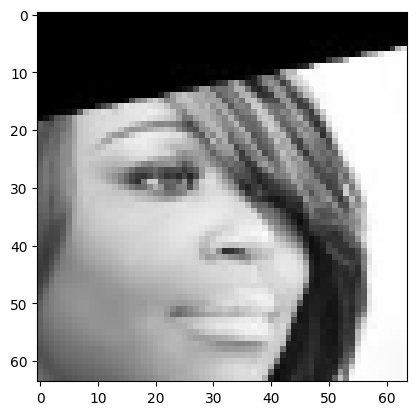

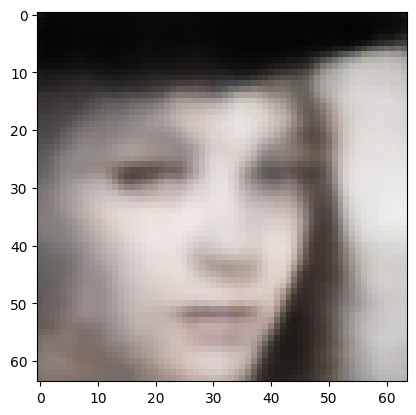

In [9]:
import matplotlib.pyplot as plt

images = []
np_images = []
i = 101

images.append(np.expand_dims(x_train[i], axis=0))
np_images = np.vstack(images)
print(x_train.shape)
print(np_images.shape)
emb = vae.encoder.predict(np_images)
print(emb)
x_decoded = vae.decoder.predict(emb)
digit = x_decoded[0].reshape(img_size, img_size, 3)
#y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
#x = cv2.cvtColor(x_test[i], cv2.COLOR_BGR2RGB)
print(x_train[i].shape)
plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.show()
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.show()

## Display a grid of sampled digits

x_train shape: (27655, 64, 64, 3)


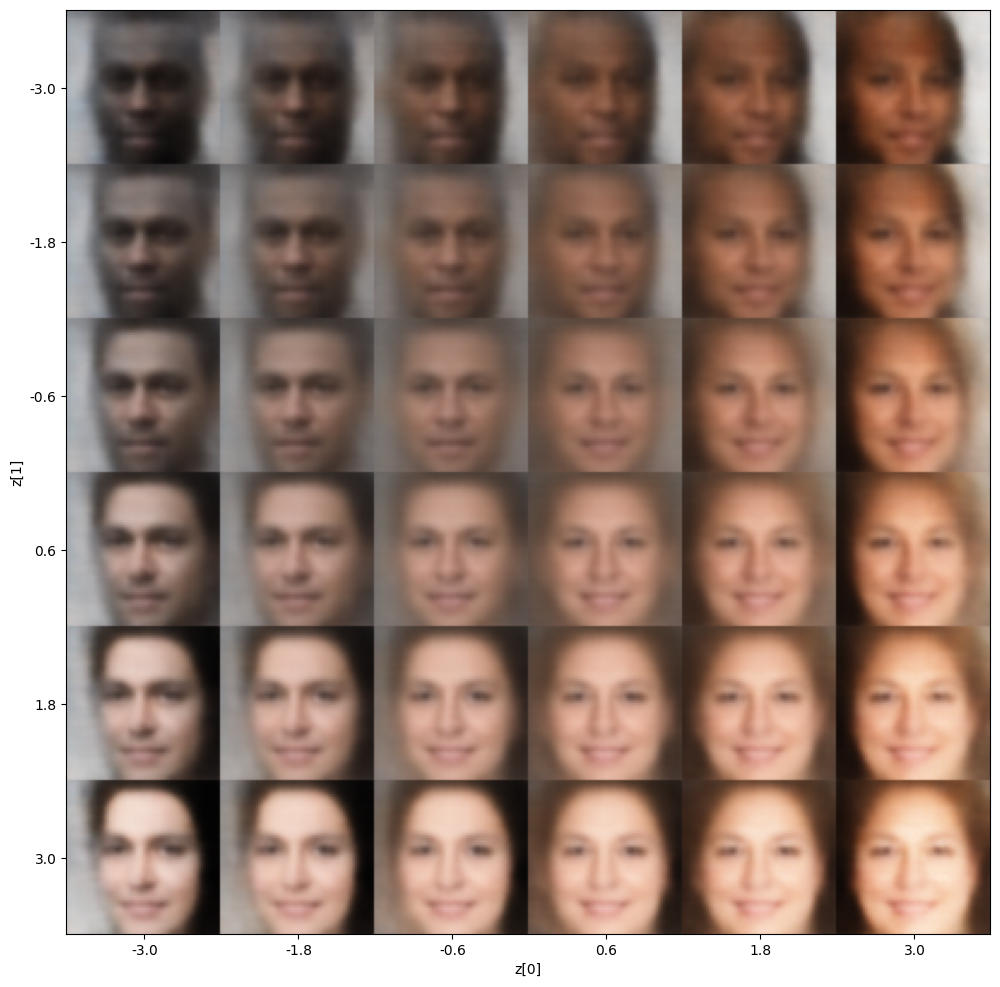

In [10]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=6, figsize=12):
    # display a n*n 2D manifold of digits

    scale = 3.0
    figure = np.zeros((img_size * n, img_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)#[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.zeros((1,latent_dim))
            #z_sample[0,:] = 1
            z_sample[0,0] = xi
            z_sample[0,3] = yi
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_size, img_size, 3)
            digit = cv2.cvtColor(digit, cv2.COLOR_BGR2RGB)
            figure[
                i * img_size : (i + 1) * img_size,
                j * img_size : (j + 1) * img_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = img_size // 2
    end_range = n * img_size + start_range
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

print('x_train shape:', x_train.shape)
plot_latent_space(vae)

векторная арифметика

(3, 64, 64, 3)
[[ 0.88253987  0.36528307 -0.1916751  -0.9439045  -0.3415195  -1.5464693
   0.09839521  0.78043485  1.2758954   0.03146803 -0.43890995 -0.23760673
  -0.02867605 -1.6484913  -0.18351597]
 [ 0.41525748  0.9385936  -0.2081609  -0.5947381  -1.2969753  -0.47007585
  -0.33773506 -1.5720892   1.1831923   0.46192098 -0.13483171 -0.90095514
  -0.35052678 -1.4540557  -0.18225195]
 [-1.4843612   0.04011869  0.04576609 -3.2308898   1.0414708  -1.1642241
   0.70923644  1.5205525   0.89469767  0.06066811 -0.22819954  1.7170043
   0.306044   -1.0338188  -1.0220455 ]]
smile [ 4.6728238e-01 -5.7331055e-01  1.6485810e-02 -3.4916639e-01
  9.5545578e-01 -1.0763935e+00  4.3613029e-01  2.3525240e+00
  9.2703104e-02 -4.3045294e-01 -3.0407822e-01  6.6334844e-01
  3.2185072e-01 -1.9443560e-01 -1.2640208e-03]
(64, 64, 3)


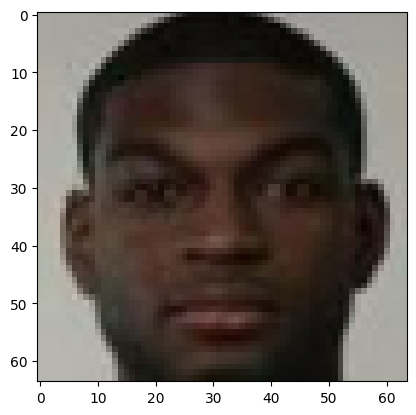

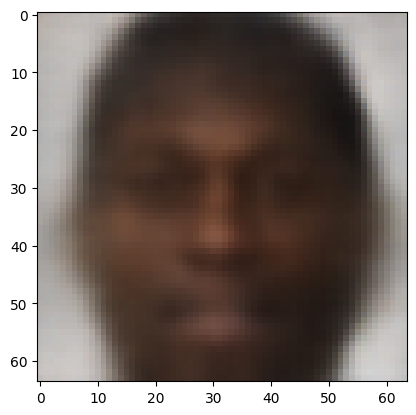

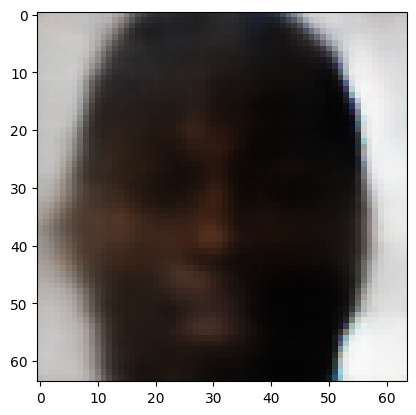

In [24]:
img1 = cv2.imread('datasets/mxnet1k/mxnet_84/6077.png') #reference with smile
img1 = cv2.resize(img1,(img_size, img_size))
img2 = cv2.imread('datasets/mxnet1k/mxnet_84/6088.png') #reference without smile
img2 = cv2.resize(img2,(img_size, img_size))
img3 = cv2.imread('datasets/mxnet1k/mxnet_52/4060.png') #new without smile
img3 = cv2.resize(img3,(img_size, img_size))

images = []
images.append(np.expand_dims(img1, axis=0))
images.append(np.expand_dims(img2, axis=0))
images.append(np.expand_dims(img3, axis=0))
np_images = np.vstack(images)
#np_images = np.expand_dims(np_images, axis=3)

np_images = np_images.astype('float32')
np_images /= 255
print(np_images.shape)

emb = vae.encoder.predict(np_images)

print(emb)
smile = emb[0]-emb[1]

print("smile", smile)

smiled_man = emb[2].copy()#+smile
smiled_man[3] -= 3

x_decoded = vae.decoder.predict(np.expand_dims(emb[2], axis=0))
digit_src = x_decoded[0].reshape(img_size, img_size, 3)

x_decoded = vae.decoder.predict(np.expand_dims(smiled_man, axis=0))
digit = x_decoded[0].reshape(img_size, img_size, 3)

img3 = img3/255
print(img3.shape)
img = np.zeros((64,64,3),float)
img[:,:,0] = img3[:,:,2]
img[:,:,1] = img3[:,:,1]
img[:,:,2] = img3[:,:,0]
plt.imshow(img, cmap="Greys_r")
plt.show()
plt.imshow(cv2.cvtColor(digit_src, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.show()
plt.imshow(cv2.cvtColor(digit, cv2.COLOR_BGR2RGB), cmap="Greys_r")
plt.show()


Гистограммы компонентов вектора улыбки

(3, 64, 64, 3)


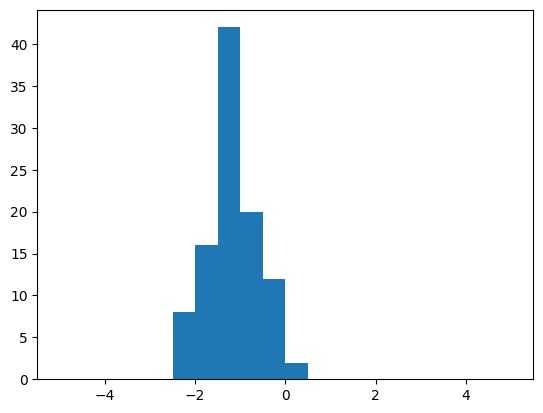

In [ ]:
img1 = cv2.imread('datasets/mxnet1k/mxnet_47/3644.png') #reference with smile
img1 = cv2.resize(img1,(img_size, img_size))
img2 = cv2.imread('datasets/mxnet1k/mxnet_47/3646.png') #reference without smile
img2 = cv2.resize(img2,(img_size, img_size))
img3 = cv2.imread('datasets/mxnet1k/mxnet_45/3494.png') #new without smile
img3 = cv2.resize(img3,(img_size, img_size))

images = []
images.append(np.expand_dims(img1, axis=0))
images.append(np.expand_dims(img2, axis=0))
images.append(np.expand_dims(img3, axis=0))
np_images = np.vstack(images)
#np_images = np.expand_dims(np_images, axis=3)

np_images = np_images.astype('float32')
np_images /= 255
print(np_images.shape)

smile_stat = np.zeros((100,latent_dim), float)
for i in range(100):
    emb = vae.encoder.predict(np_images)

    #print(emb)
    smile = emb[0]-emb[1]
    smile_stat[i] = smile
    #print("smile", smile)
plt.hist(smile_stat[:,19], 20, (-5,5))
plt.show()
